# IAEA Data Analysis
The goal of this analysis is to extract useful information from the IAEA Power Reactor Information System (PRIS) database from the perspective of a country that is evaluating the best option for nuclear buildout.

-->Insert description of the database<--

The database can be accessed at the following link: https://pris.iaea.org/pris/home.aspx

## Step 1: Data Cleaning
The dataset used in this analysis was webscraped from the PRIS website where not every field is populated for every reactor. The following codeblock shows several sample rows from the dataset where it can be seen that the data contain a mix of shutdown reactors, operating reactors, and reactors under construction. The fields that have missing data (containing either "None", "NaN", or "Missing ID") are primarily determined by the operational status of the reactor.

One other field that needs to be cleaned is the "energy_supplied" field which was encoded as a pandas dataframe object showing the energy supplied by the reactor and the capacity factor for each year where data was available. 

Finally, dates need to be converted to a format that will allow for easy timespan calculations and units such as "TW.h" will need to be extracted from cells and standardized in column names.

In [1]:
import pandas as pd

df = pd.read_excel('iaea_dataset.xlsx')

df

,Unnamed: 0,country,energy_supplied,name,reactor_type,model,status,design_net_capacity,electricity_supplied,owner,...,first_criticality_date,first_grid_connection,longterm_shutdown_date,restart_date,permanent_shutdown_date,commercial_operation_date,load_factor,operation_factor,energy_availability_factor,id
0,0,ARMENIA,Year Electricity Supplied [G...,ARMENIAN-1,PWR,VVER V-270,Permanent Shutdown,376.0,25.27 TW.h,Ministry of Territorial Administration and Inf...,...,"15 Dec, 1976","22 Dec, 1976",NaN,NaN,"25 Feb, 1989","06 Oct, 1977",NC,NC,NC,1
1,1,ARMENIA,Year Electricity Supplied [GW...,ARMENIAN-2,PWR,VVER V-270,Operational,375.0,77.81 TW.h,Ministry of Territorial Administration and Inf...,...,"01 Jan, 1980","05 Jan, 1980","18 Mar, 1989","05 Nov, 1995",NaN,"03 May, 1980",64.7 %,78.7 %,65.1 %,2
2,2,ARGENTINA,Year Electricity Supplied [GW.h] Referenc...,ATUCHA-1,PHWR,PHWR KWU,Operational,319.0,101.49 TW.h,NUCLEOELECTRICA ARGENTINA S.A.,...,"13 Jan, 1974","19 Mar, 1974",NaN,NaN,NaN,"24 Jun, 1974",72.6 %,77.9 %,74.6 %,3
3,3,ARGENTINA,Year Electricity Supplied [GW.h] Referenc...,EMBALSE,PHWR,CANDU 6,Operational,608.0,146.66 TW.h,NUCLEOELECTRICA ARGENTINA S.A.,...,"13 Mar, 1983","25 Apr, 1983",NaN,NaN,NaN,"20 Jan, 1984",72.7 %,77.0 %,78.7 %,4
4,4,ARGENTINA,Year Electricity Supplied [GW.h] Reference...,ATUCHA-2,PHWR,PHWR KWU,Operational,692.0,25.44 TW.h,NUCLEOELECTRICA ARGENTINA S.A.,...,"03 Jun, 2014","25 Jun, 2014",NaN,NaN,NaN,"26 May, 2016",53.6 %,74.6 %,53.9 %,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078,1078,BANGLADESH,None,ROOPPUR-2,PWR,VVER V-523,Under Construction,1080.0,Missing ID,Bangladesh Atomic Energy Commission,...,NaN,NaN,NaN,NaN,NaN,NaN,Missing ID,Missing ID,Missing ID,1079
1079,1079,TÜRKIYE,None,AKKUYU-2,PWR,VVER V-509,Under Construction,1114.0,Missing ID,Akkuyu Nuclear Joint Stock Company (JSC),...,NaN,NaN,NaN,NaN,NaN,NaN,Missing ID,Missing ID,Missing ID,1080
1080,1080,TÜRKIYE,None,AKKUYU-3,PWR,VVER V-509,Under Construction,1114.0,Missing ID,Akkuyu Nuclear Joint Stock Company (JSC),...,NaN,NaN,NaN,NaN,NaN,NaN,Missing ID,Missing ID,Missing ID,1081
1081,1081,TÜRKIYE,None,AKKUYU-4,PWR,VVER V-509,Under Construction,1114.0,Missing ID,Akkuyu Nuclear Joint Stock Company (JSC),...,NaN,NaN,NaN,NaN,NaN,NaN,Missing ID,Missing ID,Missing ID,1082


In [2]:
def process_col(name):
    return " ".join([word.capitalize() for word in name.split("_")]) 

df = (
    df.drop(['Unnamed: 0'], axis=1)
    .rename(process_col, axis="columns")
    .rename(columns={
        "Design Net Capacity": "Design Net Capacity (MWe)",
        "Electricity Supplied": "Electricity Supplied (TWh)"
    })
    .applymap(lambda x: "None" if x == "Missing ID" or pd.isna(x) else x)
)

id_col = df.pop("Id")
df.insert(0, id_col.name, id_col)

df.tail(2)

,Id,Country,Energy Supplied,Name,Reactor Type,Model,Status,Design Net Capacity (MWe),Electricity Supplied (TWh),Owner,...,Construction Start Date,First Criticality Date,First Grid Connection,Longterm Shutdown Date,Restart Date,Permanent Shutdown Date,Commercial Operation Date,Load Factor,Operation Factor,Energy Availability Factor
1081,1082,TÜRKIYE,None,AKKUYU-4,PWR,VVER V-509,Under Construction,1114.0,None,Akkuyu Nuclear Joint Stock Company (JSC),...,"21 Jul, 2022",None,None,None,None,None,None,None,None,None
1082,1083,CHINA,None,ZHANGZHOU-1,PWR,HPR1000,Under Construction,1126.0,None,None,...,"16 Oct, 2019",None,None,None,None,None,None,None,None,None


In [3]:
def process_date(date):
    return date if date == "None" else datetime.strptime(date, "%d %b, %Y")

from datetime import datetime 

df["Construction Start Date"] = df["Construction Start Date"].map(process_date)
df["First Criticality Date"] = df["First Criticality Date"].map(process_date)
df["First Grid Connection"] = df["First Grid Connection"].map(process_date)
df["Longterm Shutdown Date"] = df["Longterm Shutdown Date"].map(process_date)
df["Restart Date"] = df["Restart Date"].map(process_date)
df["Permanent Shutdown Date"] = df["Permanent Shutdown Date"].map(process_date)
df["Commercial Operation Date"] = df["Commercial Operation Date"].map(process_date)

In [4]:
def calc_duration(row, col_start, col_end):
    if row[col_start] == "None" or row[col_end] == "None":
        return "None"
    return row[col_end] - row[col_start]
    
df["Construction Duration"] = df.apply(lambda row: calc_duration(row, "Construction Start Date", "First Grid Connection"), axis=1)
df["Commissioning Duration"] = df.apply(lambda row: calc_duration(row, "First Grid Connection", "Commercial Operation Date"), axis=1)
df["Operation Duration"] = df.apply(lambda row: calc_duration(row, "Commercial Operation Date", "Permanent Shutdown Date"), axis=1)

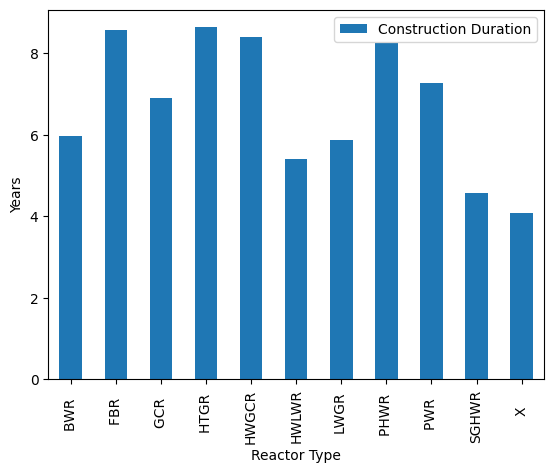

In [5]:
import matplotlib.pyplot as plt

from datetime import timedelta



plot_data = df.query('`Reactor Type` != "None" & `Construction Duration` != "None"').groupby("Reactor Type")["Construction Duration"].mean().reset_index()

plot_data["Construction Duration"] = plot_data["Construction Duration"].map(lambda x: x.days / 365.2425)

plot_data.plot.bar(x="Reactor Type",y="Construction Duration")
plt.xlabel('Reactor Type')
plt.ylabel('Years')
plt.show()

One of the major advantages that nuclear power plants have over other forms of baseload energy generation such as natural gas plants is that the energy density of the fuel is so high that fuel costs are relatively low once the plant is actually build and operational. However, the process of building a nuclear plant is very complex and often takes longer than scheduled. The additional time it takes to start generating power from a nuclear plant compared to a natural gas plant makes natural gas plants a much more attractive investment opportunity; it will be constructed much more quickly and be able to start selling electricity sooner, which means investors will be able to break even and realize a return on their investment sooner.

Because of the critical importance of having a low build time, the first area of investigation will focus on the build time of different types and models of reactors.

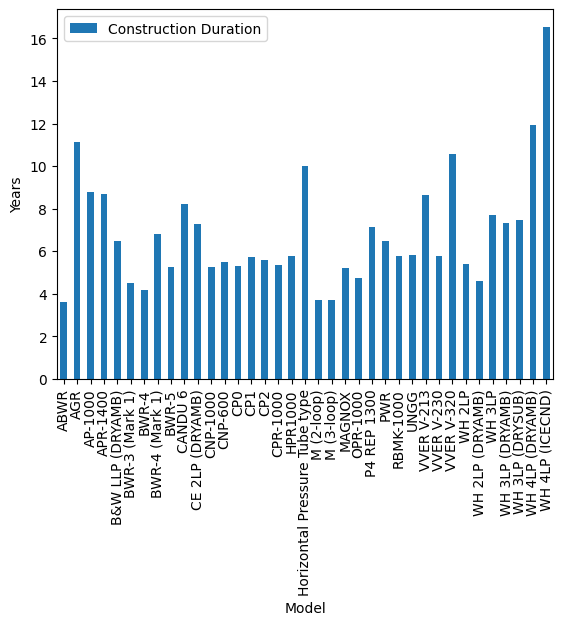

In [6]:
plot_data = df.query('`Model` != "None" & `Construction Duration` != "None"').groupby("Model")["Construction Duration"].mean().reset_index()

plot_data["Construction Duration"] = plot_data["Construction Duration"].map(lambda x: x.days / 365.2425)

plot_data['count'] = plot_data['Model'].map(df['Model'].value_counts())
plot_data = plot_data[plot_data["count"] > 5]
plot_data
plot_data.plot.bar(x="Model",y="Construction Duration")
plt.xlabel('Model')
plt.ylabel('Years')
plt.show()

Since the construction duration was calculated based on the raw time difference between the start of construction and the first grid connection, there are likely several outliers in the data due to factors such as protests, political instability, and economic instability that delayed construction for reasons other than the inherit complexity of the design and aptitude of the construction crew.

To eliminate these outliers from the data, the following code chunk will calculate a Z Score 

In [10]:
import numpy as np
from scipy import stats
duration_data = df.query('`Construction Duration` != "None"')
duration_data["Construction Duration"] = duration_data["Construction Duration"].map(lambda x: x.days)
duration_data["Duration Z Score"] = (stats.zscore(duration_data["Construction Duration"]))
duration_data[duration_data["Duration Z Score"] > 2.5]

/tmp/ipykernel_870/2123375929.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duration_data["Construction Duration"] = duration_data["Construction Duration"].map(lambda x: x.days)
/tmp/ipykernel_870/2123375929.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duration_data["Duration Z Score"] = (stats.zscore(duration_data["Construction Duration"]))


,Id,Country,Energy Supplied,Name,Reactor Type,Model,Status,Design Net Capacity (MWe),Electricity Supplied (TWh),Owner,...,Restart Date,Permanent Shutdown Date,Commercial Operation Date,Load Factor,Operation Factor,Energy Availability Factor,Construction Duration,Commissioning Duration,Operation Duration,Duration Z Score
4,5,ARGENTINA,Year Electricity Supplied [GW.h] Reference...,ATUCHA-2,PHWR,PHWR KWU,Operational,692.0,25.44 TW.h,NUCLEOELECTRICA ARGENTINA S.A.,...,None,None,2016-05-26 00:00:00,53.6 %,74.6 %,53.9 %,12034,"701 days, 0:00:00",None,6.476381
24,25,BRAZIL,Year Electricity Supplied [GW.h] Referenc...,ANGRA-2,PWR,PRE KONVOI,Operational,1245.0,200.84 TW.h,ELETROBRAS ELETRONUCLEAR S.A.,...,None,None,2001-02-01 00:00:00,84.4 %,88.9 %,86.7 %,8968,"195 days, 0:00:00",None,4.375385
247,248,UNITED KINGDOM,Year Electricity Supplied [G...,DUNGENESS B-1,GCR,AGR,Permanent Shutdown,607.0,94.58 TW.h,EDF Energy,...,None,2021-06-07 00:00:00,1985-04-01 00:00:00,42.1 %,51.4 %,43.0 %,6393,"729 days, 0:00:00","13216 days, 0:00:00",2.610849
248,249,UNITED KINGDOM,Year Electricity Supplied [G...,DUNGENESS B-2,GCR,AGR,Permanent Shutdown,607.0,99.59 TW.h,EDF Energy,...,None,2021-06-07 00:00:00,1989-04-01 00:00:00,47.8 %,54.9 %,48.0 %,7394,"1189 days, 0:00:00","11755 days, 0:00:00",3.296791
309,310,"IRAN, ISLAMIC REPUBLIC OF",Year Electricity Supplied [GW.h] Referenc...,BUSHEHR-1,PWR,VVER V-446,Operational,915.0,45.95 TW.h,Nuclear Power Production and Development Co. o...,...,None,None,2013-09-23 00:00:00,64.0 %,66.8 %,71.4 %,13274,"751 days, 0:00:00",None,7.326100
420,421,MEXICO,Year Electricity Supplied [G...,LAGUNA VERDE-2,BWR,BWR-5,Operational,780.0,132.07 TW.h,None,...,None,None,1995-04-10 00:00:00,81.1 %,86.4 %,83.0 %,6372,"150 days, 0:00:00",None,2.596459
442,443,ROMANIA,Year Electricity Supplied [GW.h] Referenc...,CERNAVODA-2,PHWR,CANDU 6,Operational,650.0,76.33 TW.h,"Ministerul Economiei, Comertului si mediului d...",...,None,None,2007-11-01 00:00:00,93.7 %,95.0 %,93.6 %,8803,"86 days, 0:00:00",None,4.262317
494,495,RUSSIA,Year Electricity Supplied [GW.h] Referenc...,KALININ-3,PWR,VVER V-320,Operational,950.0,118.79 TW.h,Joint Stock Company 'Concern Rosenergoatom',...,None,None,2005-11-08 00:00:00,86.0 %,84.8 %,84.3 %,7016,"327 days, 0:00:00",None,3.037764
495,496,RUSSIA,Year Electricity Supplied [GW.h] Referenc...,KALININ-4,PWR,VVER V-320,Operational,950.0,73.89 TW.h,Joint Stock Company 'Concern Rosenergoatom',...,None,None,2012-12-25 00:00:00,91.5 %,89.0 %,88.6 %,9246,"397 days, 0:00:00",None,4.565886
501,502,RUSSIA,Year Electricity Supplied [G...,ROSTOV-1,PWR,VVER V-320,Operational,950.0,155.92 TW.h,Joint Stock Company 'Concern Rosenergoatom',...,None,None,2001-12-25 00:00:00,91.0 %,88.6 %,87.9 %,7150,"270 days, 0:00:00",None,3.129588


Playing around with using different Z Scores, I wound up using a Z Score of 2.5 as the cutoff for including data. A spot-check of these outliers verify that the long construction durations are due to outside factors. Here are some examples of these factors:
 - ATUCHA-2: Construction was suspended in 1994 and was resumed in 2006.
 - ROVNO-4: Construction was suspended following the Chernobyl accident and was resumed in 1993
 - Watts Bar-2: Construcition was suspended in 1985 due to decreased energy demand forecast, construction resumed in 2007.
 
Simply sorting the data based on construction duration is not the best measure, since plants that generate higher amounts of electricity are likely more complex and will take longer to build. The best metric to examine would be the electrical rating of the plant divided by the number of days it took to construct the plant. 

In [13]:
duration_data = duration_data[duration_data["Duration Z Score"] < 2.5]
duration_data["MWe/Duration"] = duration_data["Design Net Capacity (MWe)"]/duration_data["Construction Duration"]
duration_data.sort_values('MWe/Duration', ascending=False).head(20)

,Id,Country,Energy Supplied,Name,Reactor Type,Model,Status,Design Net Capacity (MWe),Electricity Supplied (TWh),Owner,...,Permanent Shutdown Date,Commercial Operation Date,Load Factor,Operation Factor,Energy Availability Factor,Construction Duration,Commissioning Duration,Operation Duration,Duration Z Score,MWe/Duration
382,383,JAPAN,Year Electricity Supplied [GW.h] Referenc...,KASHIWAZAKI KARIWA-6,BWR,ABWR,Operational,1315.0,133.58 TW.h,"Tokyo Electric Power Company Holdings, Inc.",...,None,1996-11-07 00:00:00,44.8 %,44.4 %,44.3 %,1182,"283 days, 0:00:00",None,-0.960023,1.112521
383,384,JAPAN,Year Electricity Supplied [GW.h] Referenc...,KASHIWAZAKI KARIWA-7,BWR,ABWR,Operational,1315.0,116.41 TW.h,"Tokyo Electric Power Company Holdings, Inc.",...,None,1997-07-02 00:00:00,40.4 %,40.5 %,40.0 %,1265,"197 days, 0:00:00",None,-0.903147,1.039526
842,843,JAPAN,Year Electricity Supplied [GW.h] Referenc...,HAMAOKA-5,BWR,ABWR,Long-term Shutdown,1325.0,38.95 TW.h,"CHUBU ELECTRIC POWER CO., INC.",...,None,2005-01-18 00:00:00,17.7 %,17.8 %,17.3 %,1388,"263 days, 0:00:00",None,-0.818860,0.954611
375,376,JAPAN,Year Electricity Supplied [GW.h] Referenc...,HAMAOKA-4,BWR,BWR-5,Long-term Shutdown,1092.0,130.35 TW.h,"CHUBU ELECTRIC POWER CO., INC.",...,None,1993-09-03 00:00:00,49.8 %,50.2 %,49.8 %,1202,"219 days, 0:00:00",None,-0.946318,0.908486
359,360,JAPAN,Year Electricity Supplied [GW.h] Referenc...,TSURUGA-2,PWR,M (4-loop),Operational,1115.0,185.89 TW.h,JAPAN ATOMIC POWER CO.,...,None,1987-02-17 00:00:00,54.2 %,54.2 %,54.0 %,1321,"243 days, 0:00:00",None,-0.864772,0.844058
377,378,JAPAN,Year Electricity Supplied [GW.h] Referenc...,OHI-3,PWR,M (4-loop),Operational,1127.0,194.30 TW.h,Kansai Electric Power Co.,...,None,1991-12-18 00:00:00,65.4 %,64.8 %,64.5 %,1343,"194 days, 0:00:00",None,-0.849697,0.839166
841,842,JAPAN,Year Electricity Supplied [GW.h] Referenc...,SHIKA-2,BWR,ABWR,Operational,1108.0,29.30 TW.h,HOKURIKU ELECTRIC POWER CO.,...,None,2006-03-15 00:00:00,16.9 %,16.6 %,16.3 %,1414,"254 days, 0:00:00",None,-0.801044,0.783593
360,361,JAPAN,Year Electricity Supplied [GW.h] Referenc...,FUKUSHIMA-DAINI-3,BWR,BWR-5,Permanent Shutdown,1067.0,163.05 TW.h,"Tokyo Electric Power Company Holdings, Inc.",...,2019-09-30 00:00:00,1985-06-21 00:00:00,50.3 %,51.2 %,50.8 %,1362,"189 days, 0:00:00","12519 days, 0:00:00",-0.836677,0.783407
379,380,JAPAN,Year Electricity Supplied [GW.h] Referenc...,KASHIWAZAKI KARIWA-3,BWR,BWR-5,Long-term Shutdown,1067.0,100.28 TW.h,"Tokyo Electric Power Company Holdings, Inc.",...,None,1993-08-11 00:00:00,36.7 %,37.1 %,37.0 %,1372,"246 days, 0:00:00",None,-0.829824,0.777697
380,381,JAPAN,Year Electricity Supplied [GW.h] Referenc...,KASHIWAZAKI KARIWA-4,BWR,BWR-5,Long-term Shutdown,1067.0,91.85 TW.h,"Tokyo Electric Power Company Holdings, Inc.",...,None,1994-08-11 00:00:00,35.0 %,35.4 %,35.3 %,1387,"233 days, 0:00:00",None,-0.819546,0.769286


When the data are sorted based on the ratio of power supplied by the plant to the amount of time it took to build the plant, 16 of the top plants were constructed in Japan. Of those 16 Japanese plants, 12 are BWRs and 4 are PWRs. It should be noted that the low load factors shown for the Japanese plants are not indicative of poor construction or operation; many of these plants were shut down following the Fukushima accident in 2011 and were operating with high load factors prior to this.

<AxesSubplot: xlabel='Country'>

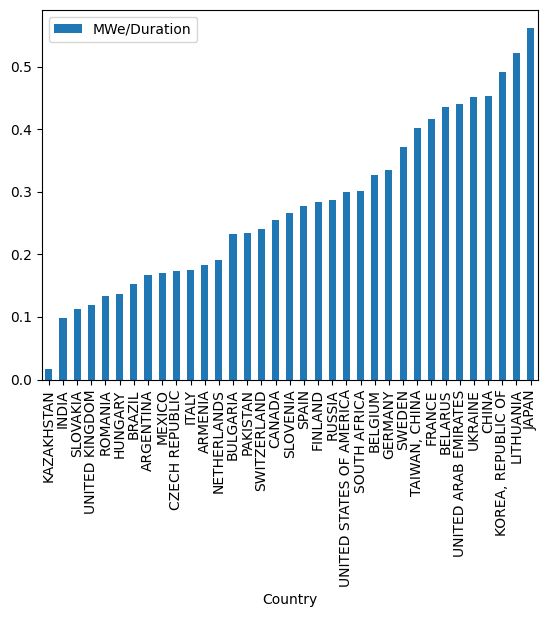

In [20]:
plot_data = duration_data.groupby("Country")["MWe/Duration"].mean().reset_index().sort_values("MWe/Duration")
plot_data.plot.bar(x="Country",y="MWe/Duration")

<AxesSubplot: xlabel='Reactor Type'>

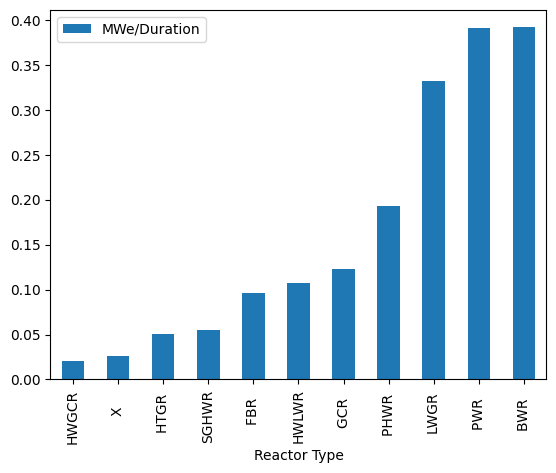

In [21]:
plot_data = duration_data.groupby("Reactor Type")["MWe/Duration"].mean().reset_index().sort_values("MWe/Duration")
plot_data.plot.bar(x="Reactor Type",y="MWe/Duration")

/tmp/ipykernel_870/2400306628.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data["Load Factor"] = plot_data["Load Factor"].map(lambda x: float(x.split(" ")[0])/100)


<AxesSubplot: xlabel='Reactor Type'>

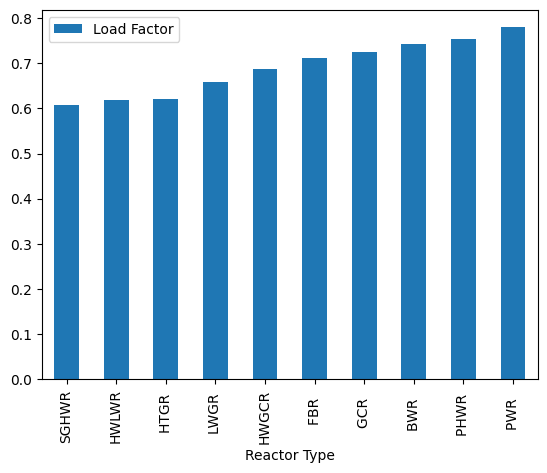

In [35]:
plot_data = df.query('`Load Factor` != "None" & `Load Factor` != "NC"')

def process_percentage(string):
    return 

plot_data["Load Factor"] = plot_data["Load Factor"].map(lambda x: float(x.split(" ")[0])/100)
plot_data = plot_data[plot_data["Load Factor"] > 0.5]
plot_data = plot_data.groupby("Reactor Type")["Load Factor"].mean().reset_index().sort_values("Load Factor")
plot_data.plot.bar(x="Reactor Type", y="Load Factor")